In [22]:
import dlib
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

## 함수1. 이미지에 입술 라인 그리기

In [23]:
def draw_lipline_on_image(img_dir):
    
    index = list(range(48, 68))
    color = (0, 255, 255)
    thickness = 2
    
    # 이미지 불러오기
    img = cv2.imread(img_dir)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 얼굴 검출(흑백이미지로)
    face_detector = dlib.get_frontal_face_detector()
    faces = face_detector(img_gray)

    face_size = 0
    num = 0

    for i, face in enumerate(faces):
        if face.area() > face_size:
            face_size = face.area()
            num = i

    # 랜드마크 검출(컬러이미지로)
    landmark_model = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    lm = landmark_model(img, faces[num])

    # 랜드마크 좌표 추출
    lm_point = [[p.x, p.y] for p in lm.parts()]
    lm_point = np.array(lm_point)

    # 입술 좌표 추출
    lip_point = [tuple(lm_point[index][i]) for i in range(len(index))]
    
    # 입술 라인 그리기
    for i in range(len(lip_point)):

        # OUTLINE 마지막 좌표
        if i == 11:
            cv2.line(img, lip_point[i], lip_point[0], color=color, thickness=thickness, lineType=cv2.LINE_AA)

        # INLINE 마지막 좌표
        elif i == 19:
            cv2.line(img, lip_point[i], lip_point[12], color=color, thickness=thickness, lineType=cv2.LINE_AA)

        else:
            cv2.line(img, lip_point[i], lip_point[i+1], color=color, thickness=thickness, lineType=cv2.LINE_AA)
            
    # 입술 좌표 y값 양수로 변경
    lip_point = [(lip_point[i][0], -lip_point[i][1]) for i in range(20)]
            
    return img, lip_point

In [24]:
img, lip_point = draw_lipline_on_image('./data/2-0-어.png')

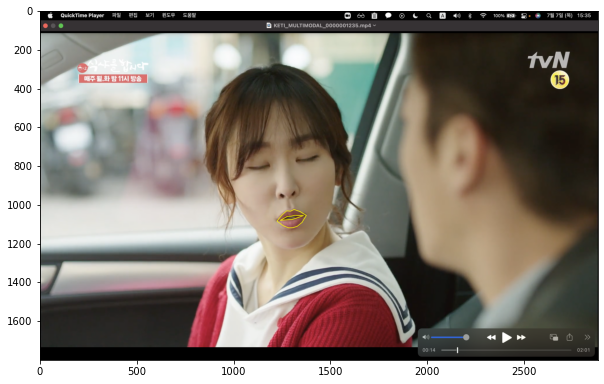

In [112]:
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## 함수2. 그래프에 입술 라인 그리기

In [26]:
def draw_lipline_on_graph(lip_point):
    
    lipOutline_x = []
    lipOutline_y = []
    lipInline_x = []
    lipInline_y = []

    for i, p in enumerate(lip_point):

        # OUTLINE
        if i < 11:
            lipOutline_x.append(p[0])
            lipOutline_y.append(p[1])

        elif i == 11:
            lipOutline_x.append(p[0])
            lipOutline_x.append(lip_point[0][0])
            lipOutline_y.append(p[1])
            lipOutline_y.append(lip_point[0][1])

        # INLINE
        elif i > 11 and i < 19:
            lipInline_x.append(p[0])
            lipInline_y.append(p[1])

        elif i == 19:
            lipInline_x.append(p[0])
            lipInline_x.append(lip_point[12][0])
            lipInline_y.append(p[1])
            lipInline_y.append(lip_point[12][1])
    
    return lipOutline_x, lipOutline_y, lipInline_x, lipInline_y

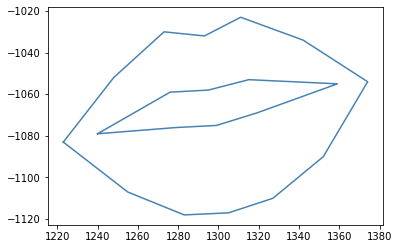

In [86]:
lipOutline_x, lipOutline_y, lipInline_x, lipInline_y = draw_lipline_on_graph(lip_point)
plt.plot(lipOutline_x, lipOutline_y, 'steelblue')
plt.plot(lipInline_x, lipInline_y, 'steelblue')
plt.show()

## 함수3. Procrustes Analysis

### Translation(원점 이동), Aligning(회전)  ⇒ y축 기준
- 입술의 x축은 수평이 아님(웃으면서 말하기 등 발화 상황에 따라 달라짐)
- 입술의 y축은 항상 수직임(한쪽 입꼬리를 올려서 말하기 등 특수한 상황을 제외한 평범한 발화시)

### Scaling(크기 맞춤) ⇒ y축 기준
- 입술은 x축 대칭이 아님(윗입술/아랫입술 두께 다름)
- 입술은 y축 대칭임

In [40]:
def procrustes_analysis(lip_point):
    
    # Translation
    lip_point_translation = [(lip_point[i][0]-lip_point[9][0], lip_point[i][1]-lip_point[9][1]) for i in range(20)]

    # Aligning
    rad = math.atan2(lip_point_translation[3][0], lip_point_translation[3][1])
    lip_point_aligning = []
    for i in range(20):
        lip_point_aligning.append((math.cos(rad)*lip_point_translation[i][0] - math.sin(rad)*lip_point_translation[i][1],
                                   math.sin(rad)*lip_point_translation[i][0] + math.cos(rad)*lip_point_translation[i][1]))
        
    # Scaling
    lip_point_scaling = lip_point_aligning / np.linalg.norm(lip_point_aligning)
    
    
    return lip_point_scaling

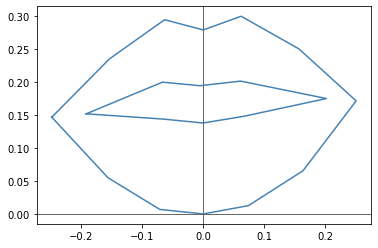

In [87]:
lip_point_procrustes = procrustes_analysis(lip_point)
lipOutline_x, lipOutline_y, lipInline_x, lipInline_y = draw_lipline_on_graph(lip_point_procrustes)
plt.plot(lipOutline_x, lipOutline_y, 'steelblue')
plt.plot(lipInline_x, lipInline_y, 'steelblue')
plt.axvline(x=0, color='dimgray', linewidth=1)
plt.axhline(y=0, color='dimgray', linewidth=1)
plt.show()

In [106]:
def draw_procrustes_analysis_graph(lip_point):
    
    # Translation
    lip_point_translation = [(lip_point[i][0]-lip_point[9][0], lip_point[i][1]-lip_point[9][1]) for i in range(20)]

    # Aligning
    rad = math.atan2(lip_point_translation[3][0], lip_point_translation[3][1])
    lip_point_aligning = []
    for i in range(20):
        lip_point_aligning.append((math.cos(rad)*lip_point_translation[i][0] - math.sin(rad)*lip_point_translation[i][1],
                                   math.sin(rad)*lip_point_translation[i][0] + math.cos(rad)*lip_point_translation[i][1]))
        
    # Scaling
    lip_point_scaling = lip_point_aligning / np.linalg.norm(lip_point_aligning)

    # Graph
    plt.figure(figsize=(16, 10))

    plt.subplot(2, 2, 1)
    plt.title('Original')
    lipOutline_x, lipOutline_y, lipInline_x, lipInline_y = draw_lipline_on_graph(lip_point)
    plt.plot(lipOutline_x, lipOutline_y, 'steelblue')
    plt.plot(lipInline_x, lipInline_y, 'steelblue')

    plt.subplot(2, 2, 2)
    plt.title('After Translation')
    lipOutline_x, lipOutline_y, lipInline_x, lipInline_y = draw_lipline_on_graph(lip_point_translation)
    plt.plot(lipOutline_x, lipOutline_y, 'steelblue')
    plt.plot(lipInline_x, lipInline_y, 'steelblue')

    ax1 = plt.subplot(2, 2, 4)
    plt.title('After Scaling')
    lipOutline_x, lipOutline_y, lipInline_x, lipInline_y = draw_lipline_on_graph(lip_point_scaling)
    plt.plot(lipOutline_x, lipOutline_y, 'steelblue')
    plt.plot(lipInline_x, lipInline_y, 'steelblue')
    
    ax2 = plt.subplot(2, 2, 3, sharex=ax1, sharey=ax1)
    plt.title('After Aligning')
    lipOutline_x, lipOutline_y, lipInline_x, lipInline_y = draw_lipline_on_graph(lip_point_aligning)
    plt.plot(lipOutline_x, lipOutline_y, 'steelblue')
    plt.plot(lipInline_x, lipInline_y, 'steelblue')

    plt.show()

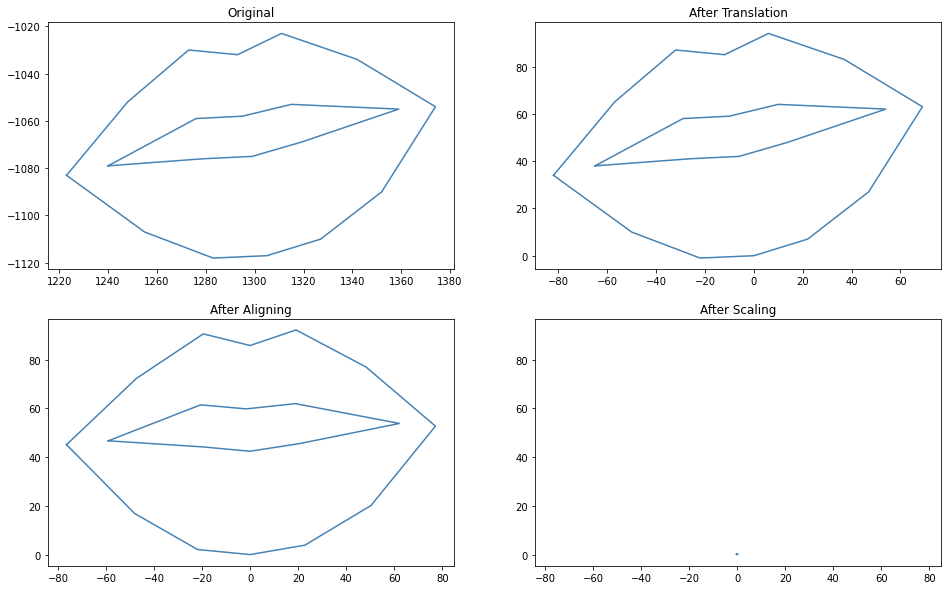

In [107]:
draw_procrustes_analysis_graph(lip_point)

## 함수4. Lip_Pronunciation_Analysis

In [81]:
img_test, lip_point_test = draw_lipline_on_image('./data/2-0-어-test.png')

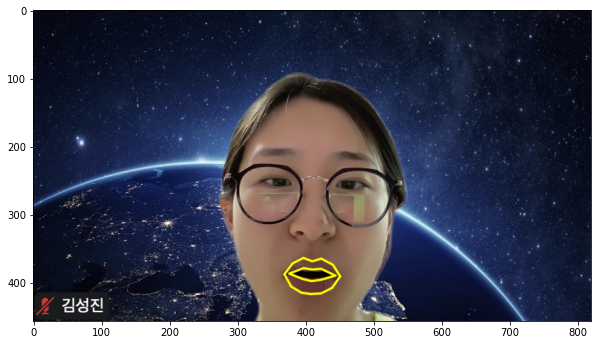

In [82]:
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
plt.show()

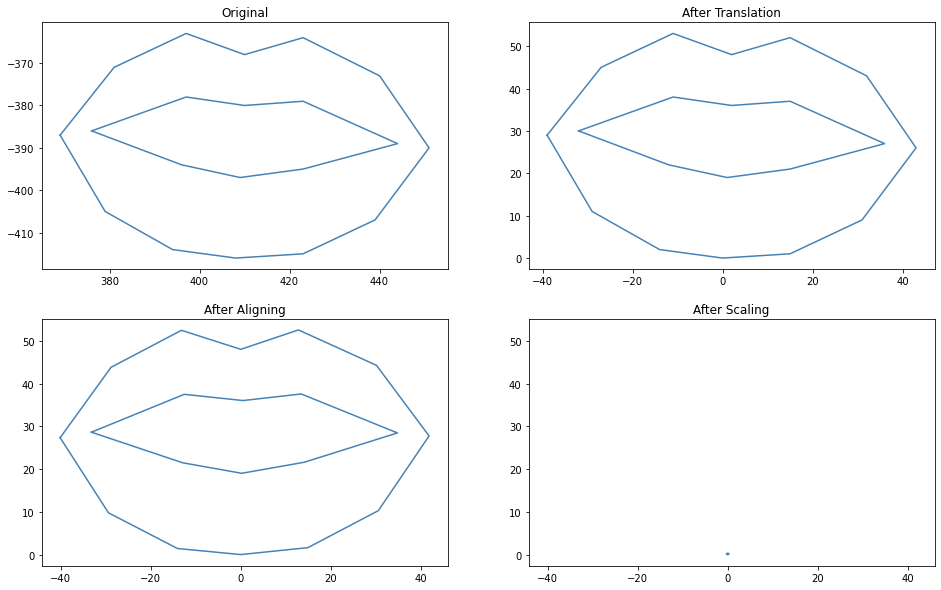

In [108]:
draw_procrustes_analysis_graph(lip_point_test)

In [84]:
def Lip_Pronunciation_Analysis(lip_point, lip_point_test):
    
    lip_point_procrustes = procrustes_analysis(lip_point)
    lip_point_procrustes_test = procrustes_analysis(lip_point_test)
    
    score = np.sum(np.square(lip_point_procrustes - lip_point_procrustes_test))
    
    return score

In [85]:
Lip_Pronunciation_Analysis(lip_point, lip_point_test)

0.005422270831939858

In [109]:
def draw_Lip_Pronunciation_Analysis_graph(lip_point, lip_point_test):
    
    # Translation
    lip_point_translation = [(lip_point[i][0]-lip_point[9][0], lip_point[i][1]-lip_point[9][1]) for i in range(20)]
    lip_point_translation_test = [(lip_point_test[i][0]-lip_point_test[9][0], lip_point_test[i][1]-lip_point_test[9][1]) for i in range(20)]

    # Aligning
    rad = math.atan2(lip_point_translation[3][0], lip_point_translation[3][1])
    lip_point_aligning = []
    for i in range(20):
        lip_point_aligning.append((math.cos(rad)*lip_point_translation[i][0] - math.sin(rad)*lip_point_translation[i][1],
                                   math.sin(rad)*lip_point_translation[i][0] + math.cos(rad)*lip_point_translation[i][1]))
    rad = math.atan2(lip_point_translation_test[3][0], lip_point_translation_test[3][1])
    lip_point_aligning_test = []
    for i in range(20):
        lip_point_aligning_test.append((math.cos(rad)*lip_point_translation_test[i][0] - math.sin(rad)*lip_point_translation_test[i][1],
                                   math.sin(rad)*lip_point_translation_test[i][0] + math.cos(rad)*lip_point_translation_test[i][1]))
        
    # Scaling
    lip_point_scaling = lip_point_aligning / np.linalg.norm(lip_point_aligning)
    lip_point_scaling_test = lip_point_aligning_test / np.linalg.norm(lip_point_aligning_test)

    # Graph
    plt.figure(figsize=(16, 10))

    plt.subplot(2, 2, 1)
    plt.title('Original')
    lipOutline_x, lipOutline_y, lipInline_x, lipInline_y = draw_lipline_on_graph(lip_point)
    plt.plot(lipOutline_x, lipOutline_y, 'steelblue')
    plt.plot(lipInline_x, lipInline_y, 'steelblue')
    lipOutline_x_test, lipOutline_y_test, lipInline_x_test, lipInline_y_test = draw_lipline_on_graph(lip_point_test)
    plt.plot(lipOutline_x_test, lipOutline_y_test, 'orange')
    plt.plot(lipInline_x_test, lipInline_y_test, 'orange')

    plt.subplot(2, 2, 2)
    plt.title('After Translation')
    lipOutline_x, lipOutline_y, lipInline_x, lipInline_y = draw_lipline_on_graph(lip_point_translation)
    plt.plot(lipOutline_x, lipOutline_y, 'steelblue')
    plt.plot(lipInline_x, lipInline_y, 'steelblue')
    lipOutline_x_test, lipOutline_y_test, lipInline_x_test, lipInline_y_test = draw_lipline_on_graph(lip_point_translation_test)
    plt.plot(lipOutline_x_test, lipOutline_y_test, 'orange')
    plt.plot(lipInline_x_test, lipInline_y_test, 'orange')
    
    plt.subplot(2, 2, 3)
    plt.title('After Aligning')
    lipOutline_x, lipOutline_y, lipInline_x, lipInline_y = draw_lipline_on_graph(lip_point_aligning)
    plt.plot(lipOutline_x, lipOutline_y, 'steelblue')
    plt.plot(lipInline_x, lipInline_y, 'steelblue')
    lipOutline_x_test, lipOutline_y_test, lipInline_x_test, lipInline_y_test = draw_lipline_on_graph(lip_point_aligning_test)
    plt.plot(lipOutline_x_test, lipOutline_y_test, 'orange')
    plt.plot(lipInline_x_test, lipInline_y_test, 'orange')

    plt.subplot(2, 2, 4)
    plt.title(f'After Scaling - Score:{Lip_Pronunciation_Analysis(lip_point, lip_point_test)}')
    lipOutline_x, lipOutline_y, lipInline_x, lipInline_y = draw_lipline_on_graph(lip_point_scaling)
    plt.plot(lipOutline_x, lipOutline_y, 'steelblue')
    plt.plot(lipInline_x, lipInline_y, 'steelblue')
    lipOutline_x_test, lipOutline_y_test, lipInline_x_test, lipInline_y_test = draw_lipline_on_graph(lip_point_scaling_test)
    plt.plot(lipOutline_x_test, lipOutline_y_test, 'orange')
    plt.plot(lipInline_x_test, lipInline_y_test, 'orange')

    plt.show()

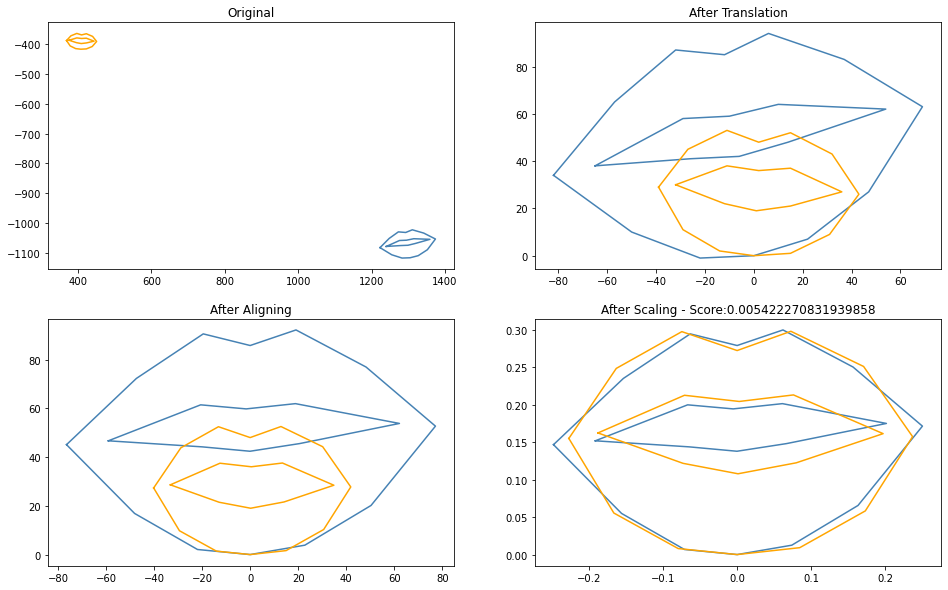

In [110]:
draw_Lip_Pronunciation_Analysis_graph(lip_point, lip_point_test)